In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
# import simpreglib as srl
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats

from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/cleaned_kc.csv')

In [55]:
def create_vif_dictionary(X):
    """
    Parameters
    ----------
    X: Pandas dataframe of predictive variables only.
        Should have `.columns` and `.values` attributes.
    """
    
    vif_dct = {}

    # Loop through each row and set the variable name to the VIF. 
    for i in range(len(X.columns)):
        # Calculate VIF
        vif = variance_inflation_factor(X.values, i)
        
        # Extract column name for dictionary key.
        v = X.columns[i]
        
        # Set value in dictionary.
        vif_dct[v] = vif

    return vif_dct

In [3]:
# convert age to an integer
ages = []
for age in df.age:
    age = age.split()[0]
    ages.append(float(age))
df.age = ages

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21143 entries, 0 to 21142
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  21143 non-null  float64
 1   bedrooms               21143 non-null  int64  
 2   bathrooms              21143 non-null  float64
 3   sqft_living            21143 non-null  int64  
 4   sqft_lot               21143 non-null  int64  
 5   floors                 21143 non-null  float64
 6   condition              21143 non-null  int64  
 7   grade                  21143 non-null  int64  
 8   sqft_above             21143 non-null  int64  
 9   sqft_basement          21143 non-null  float64
 10  yr_built               21143 non-null  int64  
 11  sqft_living15          21143 non-null  int64  
 12  sqft_lot15             21143 non-null  int64  
 13  age                    21143 non-null  float64
 14  day_of_year            21143 non-null  int64  
 15  be

In [30]:
df.grade.value_counts()

7    8788
8    5933
9    2557
6    1997
1    1605
5     235
4      27
3       1
Name: grade, dtype: int64

In [5]:
y = df.price
X_labels = df.columns[1:]
X = df[X_labels]

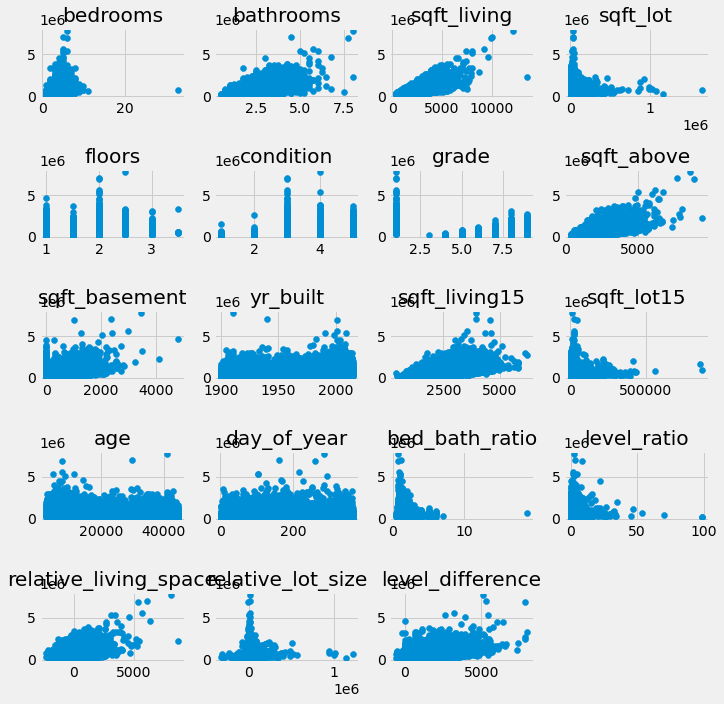

In [28]:
# visualize the relationship between the predictors and the target using scatterplots
plt.figure(figsize=(10,10))

for idx,label in enumerate(X_labels):
    ax = plt.subplot(5,4,idx+1)
    plt.scatter(X[label],y)
    plt.title(label)

plt.tight_layout()
plt.show()

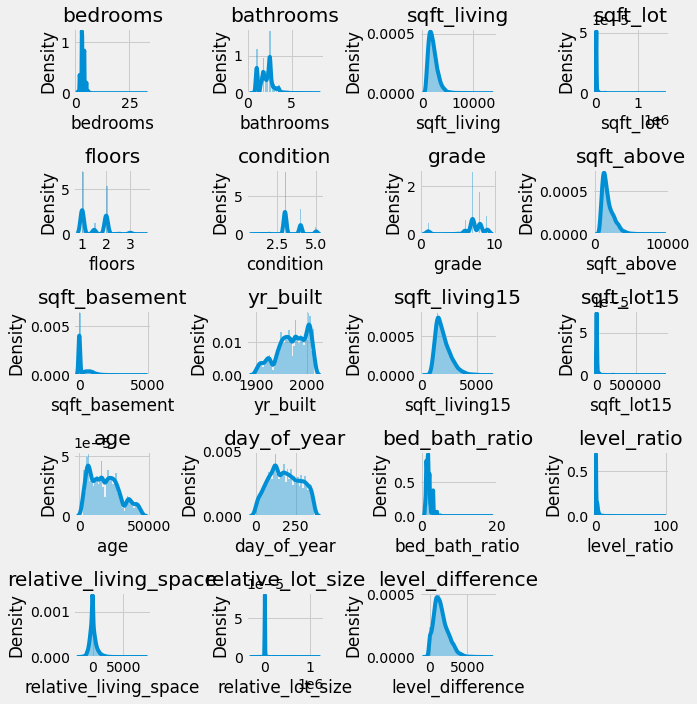

In [27]:
plt.figure(figsize=(10,10))

for idx,label in enumerate(X_labels):
    ax = plt.subplot(5,4,idx+1)
    sns.distplot(X[label],hist=True)
    plt.title(label)

plt.tight_layout()
plt.show()

In [46]:
# plt.figure(figsize=(10,10))

# for label in X_labels:
#     sm.qqplot(X[label],line='45')
#     plt.title(label)
#     plt.show()


### One-hot encoding for categorical vairables

In [51]:
# one hot encode categorical variables into their own dataframes

floor_cats = X.floors.astype('category')
floor_dummies = pd.get_dummies(floor_cats,prefix='floor',drop_first=True)

cond_cats = X.floors.astype('category')
cond_dummies = pd.get_dummies(cond_cats,prefix='cond',drop_first=True)

grade_cats = X.floors.astype('category')
grade_dummies = pd.get_dummies(grade_cats,prefix='grade',drop_first=True)


In [52]:
model_data = pd.concat([X,floor_dummies,cond_dummies,grade_dummies],axis=1)
model_data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,...,cond_1.5,cond_2.0,cond_2.5,cond_3.0,cond_3.5,grade_1.5,grade_2.0,grade_2.5,grade_3.0,grade_3.5
0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,...,0,0,0,0,0,0,0,0,0,0
1,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,...,0,1,0,0,0,0,1,0,0,0
2,2,1.00,770,10000,1.0,3,6,770,0.0,1933,...,0,0,0,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,...,0,0,0,0,0,0,0,0,0,0
4,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,...,0,0,0,0,0,0,0,0,0,0


In [53]:
predictors_int = sm.add_constant(X)
model = sm.OLS(y,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2064.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:51:30   Log-Likelihood:            -2.9143e+05
No. Observations:               21143   AIC:                         5.829e+05
Df Residuals:                   21127   BIC:                         5.830e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.263e+09   4.29e+09     -0.760      0.447   -1.17e+10    5.15e+09
bedrooms              -1.128e+05   3960.764    -28.481      0.000   -1.21e+05   -1.05e+05
bathrooms              1.641e+05   6848.789     23.962      0.000    1.51e+05    1.78e+05
sqft_living             179.6507     55.099      3.261      0.001      71.653     287.648
sqft_lot                669.8321    881.561      0.760      0.447   -1058.095    2397.759
floors                 6.675e+04   4155.203     16.063      0.000    5.86e+04    7.49e+04
condition              2.678e+04   2711.449      9.876      0.000    2.15e+04    3.21e+04
grade                 -2.184e+04    928.255    -23.525      0.000   -2.37e+04      -2e+04
sqft_above               37.9199     36.696      1.033      0.301     -34.007     109.846
sqft_basement            44.8588     35.716      1.256      0.209     -25.147     114.865
yr_built               1.614e+06   2.12e+06      0.760      0.447   -2.55e+06    5.78e+06
sqft_living15           103.8124     18.991      5.466      0.000      66.588     141.036
sqft_lot15             -670.5143    881.562     -0.761      0.447   -2398.442    1057.414
age                    4426.1914   5813.060      0.761      0.446   -6967.849    1.58e+04
day_of_year             -86.0035     17.036     -5.048      0.000    -119.395     -52.612
bed_bath_ratio          1.07e+05   6227.810     17.176      0.000    9.48e+04    1.19e+05
level_ratio            7360.0439    661.154     11.132      0.000    6064.132    8655.955
relative_living_space     5.2546     19.019      0.276      0.782     -32.024      42.533
relative_lot_size      -669.8614    881.562     -0.760      0.447   -2397.789    1058.067
level_difference         -5.8028      1.763     -3.292      0.001      -9.258      -2.348
==============================================================================
Omnibus:                    14260.815   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           622473.822
Skew:                           2.690   Prob(JB):                         0.00
Kurtosis:                      29.031   Cond. No.                     3.21e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.03e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [58]:
create_vif_dictionary(X)

{'bedrooms': 73.76310956046437,
 'bathrooms': 91.39654464798058,
 'sqft_living': inf,
 'sqft_lot': inf,
 'floors': 16.72854086309078,
 'condition': 34.06316953981554,
 'grade': 17.191305923946146,
 'sqft_above': inf,
 'sqft_basement': inf,
 'yr_built': 148.17019700463214,
 'sqft_living15': inf,
 'sqft_lot15': inf,
 'age': 6.919799947169417,
 'day_of_year': 4.7919730569230925,
 'bed_bath_ratio': 52.25170463220655,
 'level_ratio': 1.3220986889553412,
 'relative_living_space': inf,
 'relative_lot_size': inf,
 'level_difference': inf}

#### Simple linear regression on select features
Assumtion check: 
- is it linear?
- is it normal?
    - histogram
    - Q-Q plot
- is it homoscedastic?